
# TABLE OF CONTENTS:
---
* [Notebook Summary](#Notebook-Summary)
* [Model Deployment Process](#Model-Deployment-Process)
* [Setup](#Setup)
    * [Notebook Parameters](#Notebook-Parameters)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Retrieve the Registered Model](#Retrieve-the-Registered-Model)
* [Retrieve the Registered Inference Environment](#Retrieve-the-Registered-Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment (Local)](#Model-Deployment-(Local))
    * [Initial Deployment](#Initial-Deployment)
    * [Update Deployment](#Update-Deployment)
    * [Webservice Testing (Local Deployment)](#Webservice-Testing-(Local-Deployment))
        * [Python SDK (Local Deployment)](#Python-SDK-(Local-Deployment))
        * [Send HTTP Request (Local Deployment)](#Send-HTTP-Request-(Local-Deployment)))
* [Model Deployment (AKS Compute Target)](#Model-Deployment-(AKS-Compute-Target))
    * [Retrieve AKS cluster](#Retrieve-AKS-cluster)
    * [Deploy the Model as AKS Webservice](#Deploy-the-Model-as-AKS-Webservice)
    * [Retrieve Existing Webservice](#Retrieve-Existing-Webservice)
    * [Webservice Testing (AKS)](#Webservice-Testing-(AKS))
        * [Python SDK (AKS)](#Python-SDK-(AKS))
        * [Send HTTP Request (AKS)](#Send-HTTP-Request-(AKS))
* [Resource Clean Up](#Resource-Clean-Up)
---

# Notebook Summary

This notebook contains instructions on how to deploy trained Azure Machine Learning (AML) models in accordance with the current Novartis F1A MLOps Process. For more informaton on the F1A MLOps Process, please have a look at the documentation on Novapedia: https://novapedia.pharma.novartis.intra/index.php/F1_Azure_MLOps_Process#How_to_Create_a_Golden_Image_in_the_Golden_Image_ACR.

The process currently supports deployment to Research Canvas, as well as deployment to an AKS cluster (by creating a webservice REST endpoint that can be called from any application). The designed MLOps process needs to be followed to ensure that security, compliance and governance requirements are respected and necessary security measures are applied to your modeling workload. This is particularly important since the Data Science infrastructure environments (**BUILD**, **VALIDATE** & **DEPLOY**) are all connected to production data and, thus, need to be treated as IT production environments with production security controls enforced. Only this designed MLOps process will be supported by the F1A platform team to deploy models to the F1A platform. Strategically, we are working on improving the MLOps process more and more towards a self-service model and more generalizability as part of future releases but at the same time we need to ensure that security, compliance and governance controls are implemented. If you have feedback on how the model deployment process can be improved or extended, please write an email to NBS.IT.TAD.F1Azure.Platform.AIMachineLearning_ORG and we will consider your feedback in our MLOps process backlog.

Specifically, this notebook will explain the MLOps process by providing an implementation based on the example model trained in the `02_model_training` notebook. Certain customization might be required for your individual workload; however, please note that following the framework process is obligatory (e.g. the use of provided Azure DevOps (ADO) pipelines to build your image and scan it for security vulnerabilities as well as to deploy models). If you have a specific need that requires a customized ADO pipeline, please create a SNOW request as per the Data Science documentation on Novapedia (https://novapedia.pharma.novartis.intra/index.php/F1_Azure_MLOps_Process#New_Pipelines_.28Very_Important.29). You can then collaboratively work with the F1A Platform MLOps engineers on the creation of a new ADO pipeline that suits your individual deployment needs.

**Note** For the detailed documentation of the MLOps process (incl. process diagram) please refer to https://novapedia.pharma.novartis.intra/index.php/F1_Azure_MLOps_Process#How_to_Create_a_Golden_Image_in_the_Golden_Image_ACR. Make sure to read this documentation before proceding with the Novartis F1A MlOps process.

# Model Deployment Process

As part of the current MLOps design, the first step towards model deployment in production is to create test deployments and debug your inference code (e.g. the `<PROJECT_ROOT>/src/deployment/score.py` script) in the **BUILD** stage.

**Note**: It is important for your scoring file to be placed in the directory above for the ADO pipelines to be able to pick it up for deployment.

Only two types of test deployments will be enabled from an infrastructure perspective:
- Manual test deployments to localhost (to the AML Compute Instance (CI)) -> This will create docker containers on your AML CI which need to be cleaned up after testing!
- Deployments to the **BUILD** AKS cluster via ADO pipelines

We are also working on test deployments into Research Canvas for future releases of the MLOps process. For now you should test your model with a local or AKS deployment and then deploy it into Research Canvas after it has passed the necessary signoff pipelines in the **VALIDATE** stage.

There will be no AKS clusters attached to the AML workspace and therefore it will not be possible to deploy models manually to the AKS cluster via `model.deploy()` as shown in several example notebooks from Microsoft repositories as well as in Microsoft documentation. In order to deploy a model to the **BUILD** AKS cluster, please use the `build_stage_aks_pipeline` ADO pipeline provided in your ADO project. This pipeline will package the model into a Docker image using `model.package()` and subsequently deploy the Docker image to the **BUILD** AKS cluster.

**Note**: For more details on all provided ADO pipelines, please check the documentation on Novapedia.

Only after test deployments either to localhost or to the **BUILD** AKS cluster (or both) have been successfully tested, should the source code for the model be promoted from the GIT develop branch (or feature branch if you do not use a develop branch) to the GIT main branch (via pull request).

Once model deployments have been tested in the **BUILD** stage and the code has been merged to the main branch, the models should be evaluated as per the MLOps process and be presented to business. An approval by business is required to trigger the subsequent workflow of moving the model to the next stage, the **VALIDATE** stage. To move Azure Machine Learning models from the **BUILD** stage to the **VALIDATE** stage, you should trigger the `build_stage_model_promotion_pipeline` as well as the `build_stage_environment_promotion_pipeline` ADO pipelines. The artifacts in the main branch will be used to run the required signoff pipeline in the **VALIDATE** stage: `validate_stage_model_signoff_pipeline`. This ADO pipeline is used to run vulnerability scanning for code, package the model into a Docker image, build the image and run vulnerability scans on top of the image. Optionally (through the feature flag paramSkipDeployment) you can initiate a deployment to the **VALIDATE** AKS cluster and run a smoke test on the endpoint. If your security signoff is successful, the AML model and AML deployment environment will be promoted to the **DEPLOY** stage. A security report will be created and send to respective Novartis security teams. You will also be able to download the security report which will help you to identify the vulnerabilities that need to be remediated (if there are any). 

If no security issues have been detected, the model is ready to be deployed as a production workload into the **DEPLOY** stage. For this step, another sign off by business is required to confirm that the model will be moved into production at this point in time. In order to deploy models to standalone AKS, the  `deploy_stage_aks_pipeline` ADO pipeline must be used to copy the scanned and secured image from the AML **VALIDATE** ACR to the Published Models ACR from where it will be deployed to the **DEPLOY** AKS cluster. In the case of deployments to Research Canvas the `deploy_stage_rc_pipeline` must be used to copy the scanned and secured image from the AML **VALIDATE** ACR to the Published Models ACR from where it will be picked up by M3.

# Setup

Automatically reload modules when changes are made.

In [1]:
%load_ext autoreload
%autoreload 2

Append parent directory to sys path to be able to import created modules from src directory.

In [2]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

In [3]:
# Import libraries
import json
import matplotlib.pyplot as plt
import requests
import warnings
from azureml.core import Environment, Workspace
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AksWebservice, LocalWebservice, Webservice
from PIL import Image

# Import created modules
from src.utils.data_utils import load_data, preprocess_image

In [4]:
warnings.filterwarnings("ignore")

### Notebook Parameters

Specify the notebook parameters which are used in the source code below.

In [5]:
# Specify the AML registered model name
model_name = "fowl_model"

# Specify the deployment environment name
env_name = "fowl_classification_deploy_env"

# Define the inference entry script path
entry_script_path = "../src/deployment/score.py"

# Define the inference src directory (if used)
inference_src_dir = "../src/deployment"

# Specify the name for the local deployment
local_service_name = "fowl-clf-local-service"

# Define path to example data for webservice testing
example_data_path = "../data/fowl_data/val/chickens/000a816392d086c4.jpg"

# Specify the AKS web service scoring uri
aks_scoring_uri = "https://aks-build-dn01-dev-f1a.novartis.net/fowl-model/score"

### Connect to Workspace

In order to connect and communicate with the AML workspace, a workspace object needs to be instantiated using the AML Python SDK.

In [6]:
# Connect to the AML workspace using interactive authentication
ws = Workspace.from_config()

# Retrieve the Registered Model

Retrieve the registered model from the workspace. The model registration has been done as part of the `02_model_training` notebook or as part of the AML training pipeline.

In [7]:
model = Model(workspace=ws, name=model_name)

# Retrieve the Registered Inference Environment

Retrieve the inferencing environment from the workspace. This environment has been created as part of the `00_environment_setup` notebook.

In [8]:
env = Environment.get(workspace=ws, name=env_name)

# Inference Artifacts & Configuration

A deployment folder for artifacts that are required for inference has been created (`<PROJECT_ROOT>/src/deployment`).

This folder contains the scoring script, called score.py, which has to be created to enable inference and is used by the web service call to be able to know how to use the model.

Two functions are required in the scoring script:
1. an `init` function that executes once when the service starts - in this function you normally get the model from the model registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In addition, an inference configuration needs to be created which bundles the inference environment with the entry script (and the source directory if multiple files are required for inference).

In [9]:
# Create Inference Config
inference_config = InferenceConfig(#source_directory=inference_src_dir,
                                   entry_script=entry_script_path,
                                   environment=env)

# Model Deployment (Local)

This section describes how a local test deployment to the AML Compute Instance can be done. This method can be used for initial testing of the model and the inference configuration. For more information on troubleshooting, check [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-troubleshoot-deployment-local).

Using Docker to deploy your model as a local web service is the most common option (cells below). The other alternative is to run your code directly by using local Python scripts (e.g. load the pytorch model file and use it for scoring). For more info on this option check [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-local).

**Note**: Local deployment might not be a feasible option for all workloads, e.g. very big models.

### Initial Deployment

Run this for an initial deployment of the model as a webservice to port 6789 on localhost.

In [10]:
# Create local deployment config
local_deployment_config = LocalWebservice.deploy_configuration(port=6789)

local_service = Model.deploy(workspace=ws,
                             name=local_service_name,
                             models=[model],
                             inference_config=inference_config,
                             deployment_config=local_deployment_config)

local_service.wait_for_deployment(show_output=True)

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry azacrweudevf1aplatbld01.azurecr.io
Logging into Docker registry azacrweudevf1aplatbld01.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM azacrweudevf1aplatbld01.azurecr.io/azureml/azureml_80748e4235e597ef1c73b451273141bb
 ---> 469371686708
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 0006ba5f39ec
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjBjMzIzMjNhLWM2OWItNGU4YS1iZjFmLTE5YzYyMWViMzI4NCIsInJlc291cmNlR3JvdXBOYW1lIjoicmctZjFhZGF0YW5vZGUtcHJvZHVjdC1mMWFwbGF0LWJ1aWxkLWRldi13ZXN0ZXVyb3BlLTAxIiwiYWNjb3VudE5hbWUiOiJhbWxzLWYxYXBsYXRibGQtZGV2LXdlc3RldXJvcGUtMDEiLCJ3b3Jrc3BhY2VJZCI6IjFhM2Q5ZTk5LWQxNTEtNGRkYi05NmZhLWRjMzJhM2I5NzI0ZSJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 1c36bc113ac0
 ---> 52a098afda71
Step 4/5 : RUN mv '/var/azureml-app/tmpgew6bhw6.

If you need to debug your local deployment, these are some tips.

In order to see all docker images on your AML Compute Instance, run the following command from the terminal:

`docker images`

In order to remove an image, run:

`docker image rmi <IMAGE_ID> --force`

In order to prune the docker system (e.g. remove cache), run:

`docker system prune`

**Note**: When you do not require your image anymore, you should delete your images as too many images might lead your AML CI to enter an unusable state.

### Update Deployment

After the web service has been initially deployed, it's more efficient to use the update() method rather than starting from scratch. For more details about updating models check [this](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-update-web-service).

In [11]:
# Update to new model
local_service.update(models=[model], inference_config=inference_config)
local_service.wait_for_deployment(show_output=True)

print(local_service.state)
print(local_service.get_logs())

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry azacrweudevf1aplatbld01.azurecr.io
Logging into Docker registry azacrweudevf1aplatbld01.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM azacrweudevf1aplatbld01.azurecr.io/azureml/azureml_80748e4235e597ef1c73b451273141bb
 ---> 469371686708
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 568239747014
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjBjMzIzMjNhLWM2OWItNGU4YS1iZjFmLTE5YzYyMWViMzI4NCIsInJlc291cmNlR3JvdXBOYW1lIjoicmctZjFhZGF0YW5vZGUtcHJvZHVjdC1mMWFwbGF0LWJ1aWxkLWRldi13ZXN0ZXVyb3BlLTAxIiwiYWNjb3VudE5hbWUiOiJhbWxzLWYxYXBsYXRibGQtZGV2LXdlc3RldXJvcGUtMDEiLCJ3b3Jrc3BhY2VJZCI6IjFhM2Q5ZTk5LWQxNTEtNGRkYi05NmZhLWRjMzJhM2I5NzI0ZSJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in e26e05ea6a49
 ---> 4daee4473cd7
Step 4/5 : RUN mv '/var/azureml-app/tmppr3ol01t.

### Webservice Testing (Local Deployment)

In the following, the webservice that has been deployed to localhost (the AML Compute Instance) will be tested. The webservice can either be called using the Python SDK or by sending an HTTP request.

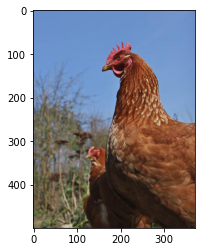

In [12]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(example_data_path))

#### Python SDK (Local Deployment)

Use the Python SDK to send input data to the service endpoint and retrieve prediction results.

In [13]:
# Preprocess the image
input_data = preprocess_image(example_data_path)

# Run the service
result = local_service.run(input_data=json.dumps({"data": input_data.tolist()}))
print(result)

{'label': 'chicken', 'probability': '0.99348503'}


#### Send HTTP Request (Local Deployment)

Send an HTTP request with the Python requests library. This is an example for how any REST API POST operation can retrieve prediction results from the model.

In [14]:
# Send an example image to get a prediction score
input_data_str = "{\"data\": " + str(input_data.tolist()) + "}"

headers = {"Content-Type": "application/json"} 

# Get scoring URI of local webservice
local_scoring_uri = local_service.scoring_uri

resp = requests.post(local_scoring_uri, input_data_str, headers=headers)

print("POST to url", local_service.scoring_uri)
print("Result:", resp.text)

POST to url http://localhost:6789/score
Result: {"label": "chicken", "probability": "0.99348503"}


# Model Deployment (AKS Compute Target)

This section describes how a test deployment to the **BUILD** AKS cluster can be done. It is only possible to deploy to the **BUILD** AKS cluster via the Azure DevOps pipeline provided in the pipeline repository. By deploying to the **BUILD** AKS cluster you can reproduce a more realistic deployment scenario than with deploying to localhost.

### Webservice Testing (AKS Deployment)

Once the webservice has been deployed to the **BUILD** AKS cluster, it will be tested. The webservice can be tested by sending an HTTP request.

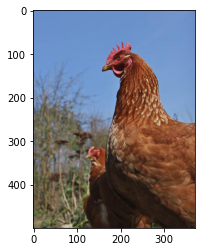

In [15]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open(example_data_path))

In [16]:
# Preprocess the image
input_data = preprocess_image(example_data_path)

#### Send HTTP Request (AKS)

Send an HTTP request with the Python requests library. This is an example for how any REST API POST operation can retrieve prediction results from the model.

In [17]:
# Send an example image to get a prediction score
input_data_str = "{\"data\": " + str(input_data.tolist()) + "}"

# For AKS deployment the service key needs to be in the header as well2
# AML generate two keys if key auth is enabled
# api_key1, api_key2 = aks_service.get_keys()
# headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key1)} 
headers = {"Content-Type": "application/json"} 

# resp = requests.post(aks_scoring_uri, input_data_str, headers=headers, verify="../cert_aks-build-dn01-dev-f1a.novartis.net.pem")
resp = requests.post(aks_scoring_uri, input_data_str, headers=headers, verify=False)

print("POST to url", aks_scoring_uri)
print("Result:", resp.text)

POST to url https://aks-build-dn01-dev-f1a.novartis.net/fowl-model/score
Result: {"label": "chicken", "probability": "0.93587804"}


Once the model has been successfully deployed and tested, the code can be merged into the main branch with a pull request. The DEV AKS cluster can, for example, be used to create a simple visualization frontend on top of the model to show the results to the business.

# Resource Clean Up

Delete the local web service with a simple API call.

In [18]:
try:
    local_service.delete()
    print("Delete local webservice...")
except:
    print("No local webservice deployed.")

Container has been successfully cleaned up.
Delete local webservice...
